In [1]:
from __future__ import print_function
import librosa
import numpy as np
import matplotlib.pyplot as plt
import json
from statistics import stdev
%matplotlib inline

In [2]:
samples_per_chunk = 300
num_chunks_per_slice = 65
num_chunks_per_beat = 8

In [3]:
def loadbeatmap(beatmap, num_beats, num_chunks_per_beat=8):
    if beatmap[len(beatmap)-5:len(beatmap)] != ".json":
        print("Beatmap file " + audio + " is not of type .json")
        return -1
    
    with open(beatmap) as f:
        data = json.load(f)
  
    notes = "_notes"
    time = "_time"
    line_index = "_lineIndex" #column number
    line_layer = "_lineLayer" #row number
    note_color = "_type" #0 is one color and 1 is the other
    cut_direction = "_cutDirection"#9 cut directions

    dim_0 = num_beats * num_chunks_per_beat
    
    # number of rows and columns in the playfield
    # number of cells in the playfield (each cell can hold at most 1 note)
    playfield_rows = 3
    playfield_cols = 4
    playfield_cell_count = playfield_rows * playfield_cols
    
    # number of colors (2): red, blue (order unknown)
    # number of directions notes can face (9): 
    # up, down, left, right, up-left, up-right, down-left, down-right, dot (order unknown)
    note_color_count = 2
    note_direction_count = 9
    
    # dimensions for a 'one-hot' representation of a single time unit (chunk)
    dim_1 = playfield_rows
    dim_2 = playfield_cols
    dim_3 = (note_color_count + 1) + note_direction_count
    
    # initialize matrix to zeros, then set the "no note" bit for each block at each timestep to 1
    outMatrix = np.zeros(shape=(dim_0, dim_1, dim_2, dim_3))
    outMatrix[:,:,:,0] = 1
    

    # for every note in the beatmap, set the color and direction bits for the proper cell to 1
    for n in range(len(data[notes])):
        entry = int(np.round(data[notes][n][time]*num_chunks_per_beat)) #convert time to row index by rounding to nearest 1/8 beat
        if data[notes][n][note_color] < 2:
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][note_color]+1] = 1
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [0] = 0
            outMatrix[entry] \
                     [data[notes][n][line_layer]] \
                     [data[notes][n][line_index]] \
                     [data[notes][n][cut_direction]+3] = 1

    return outMatrix

In [4]:
def mean_center(x): 
    return (x - np.apply_along_axis(np.mean, 0, x) )

In [5]:
def loadsong(audio, samples_per_chunk=300, num_chunks_per_slice=65, num_chunks_per_beat=8, verbose=0):
    if audio[len(audio)-4:len(audio)] != ".ogg":
        print("Audio file " + audio + " is not of type .ogg")
        return -1
    
    y, sr = librosa.load(audio)
    
    song_length = librosa.get_duration(y=y,sr=sr) / 60.0
    tempo = np.round(librosa.beat.tempo(y, sr=sr))
    new_sample_rate = (tempo/200)*8000
    
    y = librosa.resample(y, sr, new_sample_rate)
    
    number_of_beats = int(tempo * song_length)
    
    return y[0:(len(y)//(samples_per_chunk*num_chunks_per_beat)*(samples_per_chunk*num_chunks_per_beat))], new_sample_rate, number_of_beats

In [6]:
def prep_song_2(song, sample_per_chunk = 300):
    song_y = song.reshape(len(song)//300,300)
    song_fft = np.abs(np.apply_along_axis(np.fft.fft, 1, song_y))[:,0:(int)(samples_per_chunk/2)+1]
    return song_fft

In [7]:
def append_song(init_song, init_beatmap, song_filepath, beatmap_filepath, num_chunks_per_beat = 8):
    loaded_song_y, loaded_song_sr, num_beats = loadsong(song_filepath)
    
    prepped_song = prep_song_2(loaded_song_y)
    
    loaded_beatmap = loadbeatmap(beatmap_filepath, num_beats)
    
    if init_song == None and init_beatmap == None:
        init_song = []
        init_beatmap = []
        
    for i in range(num_beats*num_chunks_per_beat-256):
        init_song.append(prepped_song[i:i+256]) 
    for i in range(num_beats*num_chunks_per_beat-256):
        init_beatmap.append(loaded_beatmap[i:i+256]) 
    
    init_song = np.array(init_song)
    init_beatmap = np.array(init_beatmap)
        
    return init_song, init_beatmap

In [8]:
def data_prep(song_list, beatmap_list):
    X, Y = append_song(None, None, song_list[0], beatmap_list[0])
    for x, y in zip(song_list[1:], beatmap_list[1:]):
        X, Y = append_song(X, Y, x, y)
    
    return X, Y

In [9]:
song_y, song_sr, song_num_beats = loadsong("song.ogg")

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [10]:
song_num_beats = song_num_beats
print("Original: ",np.shape(song_y))
song_y = song_y.reshape(len(song_y)//300,300)
print("Reshaped: ",np.shape(song_y))

Original:  (1233600,)
Reshaped:  (4112, 300)


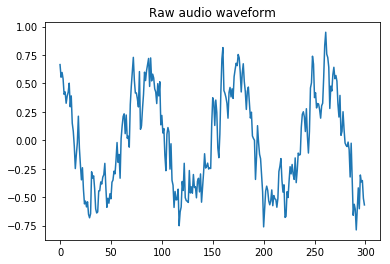

In [11]:
plt.title("Raw audio waveform")
plt.plot(range(len(song_y[0])),song_y[1000])
plt.show()

In [12]:
song_fft = np.apply_along_axis(np.fft.fft, 1, song_y)
print("Shape after Fourier transform: ",np.shape(song_fft))

Shape after Fourier transform:  (4112, 300)


/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


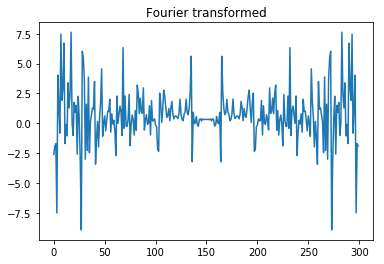

In [13]:
plt.title("Fourier transformed")
plt.plot(range(len(song_fft[0])),song_fft[1000])
plt.show()

In [14]:
song_ifft = np.apply_along_axis(np.fft.ifft, 1, song_fft)
print("Shape after inverse Fourier transform: ",np.shape(song_ifft))

Shape after inverse Fourier transform:  (4112, 300)


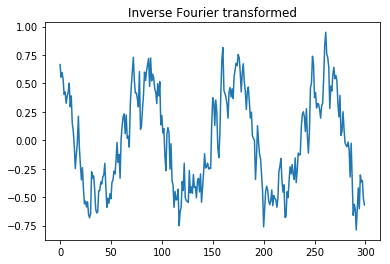

In [15]:
plt.title("Inverse Fourier transformed")
plt.plot(range(len(song_ifft[0])),song_ifft[1000])
plt.show()

In [16]:
song_fft_abs = np.apply_along_axis(np.abs, 1, song_fft)

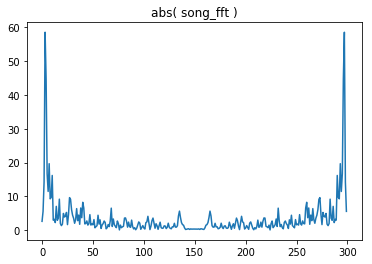

In [17]:
plt.title("abs( song_fft )")
plt.plot(range(len(song_fft_abs[0])),song_fft_abs[1000])
plt.show()

In [18]:
song_comp = np.abs(np.apply_along_axis(np.fft.fft, 1, song_y))

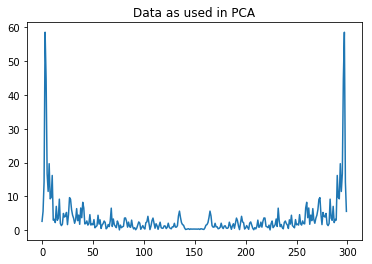

In [19]:
plt.title("Data as used in PCA")
plt.plot(range(len(song_comp[0])),song_comp[1000])
plt.show()

In [25]:
np.shape(song_comp)

(4112, 300)

In [20]:
X, Y  = data_prep(["song.ogg"], ["Expert.json"])

/nfshome/apps/python-3.6.7/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [26]:
np.shape(X)

(3856, 256, 151)

IndexError: index 1000 is out of bounds for axis 0 with size 256

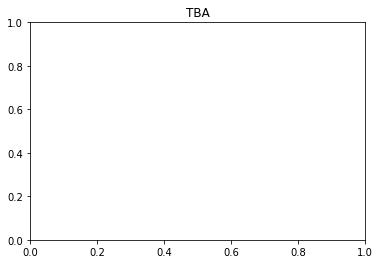

In [34]:
plt.title("TBA")
plt.plot(range(len(X[0][0])),X[1000][0])
plt.show()